In [1]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

%matplotlib ipympl

In [2]:
font = {
        'weight' : 'bold',
        'size'   : 20}
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', **font)

In [3]:
# Physical parameters
tau = 60 # total time evolution
Jhope = 1 # Energy hopping
g_0 = 0
npart = 20

alpha_gvars = (4*np.sqrt(2)*Jhope*(np.sin(np.pi/npart))**2)**(-1)
beta_gvars = np.cos(np.pi/npart)
gamma_gvars = np.sin(np.pi/npart)

temperature = 0.1 # Changes p_0
t_0 = 0

In [4]:
def g_t(t: float, gvars: dict):
  # Minimal action solution
  return gvars['beta'] + gvars['gamma'] * np.tan((1-t/gvars['tau']) * np.arctan((g_0 - gvars['beta'])/gvars['gamma'])
                                                 - t/gvars['tau'] * np.arctan((g_0 + gvars['beta'] - 2)/gvars['gamma']) )

In [5]:
def g_lin_t(t: float, gvars: dict):
    # Linear ramp solution
    return g_0 + 2 * (gvars['gc'] - g_0) * t / gvars['tau']

In [6]:
def H_k_func(k):
  Hstatic = 2* Jhope * (np.sin(k) * qutip.sigmay() - np.cos(k) * qutip.sigmaz())
  Hdinamic = 2 * qutip.sigmaz()
  H_k = [Hstatic, [Hdinamic, g_t]]
  return H_k

def H_k_lin_func(k):
  Hstatic = 2* Jhope * ( np.sin(k) * qutip.sigmay() - np.cos(k) * qutip.sigmaz() )
  Hdinamic = 2 * qutip.sigmaz()
  H_k = [Hstatic, [Hdinamic, g_lin_t]]
  return H_k

def H_k_t(t:float, k:float, gvars: dict):
  Hstatic = 2* Jhope * ( np.sin(k) * qutip.sigmay() - np.cos(k) * qutip.sigmaz() )
  Hdinamic = 2 * qutip.sigmaz()
  return Hstatic + Hdinamic * g_t(t, gvars)

def H_k_lin_t(t:float, k:float, gvars: dict):
  Hstatic = 2* Jhope * ( np.sin(k) * qutip.sigmay() - np.cos(k) * qutip.sigmaz())
  Hdinamic = 2 * qutip.sigmaz()
  return Hstatic + Hdinamic * g_lin_t(t, gvars)

## Fidelity vs. $\tau$

In [7]:
tmin = 0.5
tmax = 60
amt_times = 200 # How many points we calculate
fidel_interval = np.linspace(tmin,tmax,amt_times)

In [8]:
fidel = []
fidel_lin = []

for i in fidel_interval:
    fidelval = 1
    fidelval_lin = 1
    
    for l in range(1, int(npart/2)+1):
        k = (2*l-1)*np.pi/npart
        tlistaux = np.linspace(t_0,i,10)

        gvarsaux = {'alpha': alpha_gvars, 'beta': beta_gvars, 'gamma': gamma_gvars, 'tau': i}
        gvars_linaux = {'gc': 1, 'tau': i}

        H_k = H_k_func(k)
        H_k_lin = H_k_lin_func(k)
        
        gs_0 = H_k_t(t_0,k,gvarsaux).eigenstates()[1][0]
        gs_t = H_k_t(i,k,gvarsaux).eigenstates()[1][0]
        options = qutip.solver.Options(nsteps = 100000000, order=5)
        evol = qutip.mesolve(H_k, gs_0, tlistaux, [], [], args = gvarsaux, options = options).states
        
        gs_lin_0 = H_k_lin_t(0,k,gvars_linaux).eigenstates()[1][0]
        gs_lin_t = H_k_lin_t(i,k,gvars_linaux).eigenstates()[1][0]
        evol_lin = qutip.mesolve(H_k_lin, gs_lin_0, tlistaux, [], [], args = gvars_linaux).states

        fidelval *= np.linalg.norm(np.linalg.multi_dot([gs_t.dag(), evol[-1]]))
        fidelval_lin *= np.linalg.norm(np.linalg.multi_dot([gs_lin_t.dag(), evol_lin[-1]]))
  
    fidelval = fidelval**2
    fidelval_lin = fidelval_lin**2

    fidel += [fidelval]
    fidel_lin += [fidelval_lin]

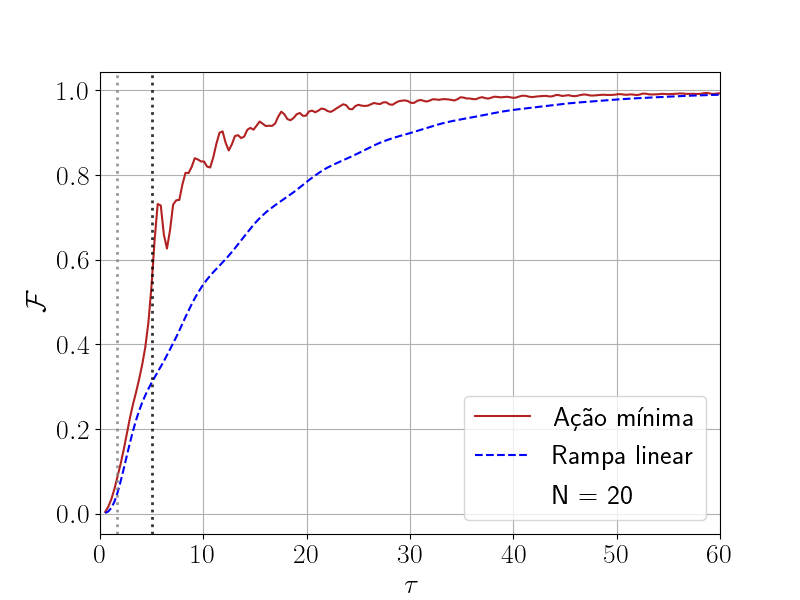

In [9]:
# Plot the results
fig, ax = plt.subplots(figsize=(8,6))

# Plot the results for linear ramp and action ramp
ax.plot(fidel_interval, fidel, color='firebrick', label='Ação mínima')
ax.plot(fidel_interval, fidel_lin, color='blue', linestyle='dashed', label='Rampa linear')
ax.plot([],[],label='N = 20', alpha=0.0)

# Add vertical lines at specific points
ax.axvline(x=1 / (4 * np.sin(np.pi / npart)), color='gray', linestyle='dotted', linewidth=2, alpha=0.8)
ax.axvline(x=npart / 4, color='black', linestyle='dotted', linewidth=2, alpha=0.8)

# Add labels and grid
ax.set_xlabel(r'$ \tau$')
ax.set_ylabel(r'$\mathcal{F}$')
ax.legend()
ax.grid()

# Show the plot
plt.xlim(0, tmax)

plt.show()